In [8]:
import os
os.chdir("..")

import numpy as np
import torch
import torchcde
from tqdm import tqdm

from src.randomizedSignature import rSig, rSigKer
from src.neuralSigKers import NeuralSigKer, OmegaKer, XiKer, NTKer, NTKer_new
from src.utils import id_phi, ReLU_phi

from src.ControlledResNets import cResNet

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Introduction

This main aim of this notebook is that of empirically testing the NTK we have found.

As an initial reminder, recall that we want to understand the behaviour under GD training of NNs of type
$$
    \Phi^{\bar\theta, N, M} (x) = \frac{1}{\sqrt{N}} \langle {v^{\bar\theta, N}}, {Y^{\bar\theta,N, M}_1(x)} \rangle
$$
where  $\bar\theta \in \bigcup_{N \geq 1} \mathbb{R}^N \times \mathbb{R}^N \times \Theta_{d,N}$ has entries $(v^{\bar\theta, N}, Y^{\bar\theta,N}_0, (A^{\bar\theta,N}_k, b^{\bar\theta,N}_k )_{k = 1, \dots, d})_{N \geq 1}$ and $Y^{\bar\theta,N,M}_1$ has initial value $Y^{\bar\theta,N}_0$ and is defined recursively as
$$
Y^{\bar\theta,N,M}_{t_{m+1}}(x) = Y^{\bar\theta,N,M}_{t_{m}}(x) +
\sum_{k=1}^d \left(A^{\bar\theta,N}_k \varphi(Y^{\bar\theta,N,M}_{t_{m}}(x)) + b^{\bar\theta,N}_k \right) (x^k_{t_{m+1}} - x^k_{t_m})
$$
for some partition $\mathcal{D}_M$ of $[0,1]$. We assume $|\mathcal{D}_M| \to 0$ as $M \to \infty$.


Our conjecture is that this behaviour is described, in the $N,M \to \infty$ limit by the NTK of form
$$
\Theta(x,y) = \mathcal{K}_{1,1}(x,y) + \Omega_{1,1}(x,y)
+ \Xi_{1,1}(x,y)
$$
with
$$
\mathcal{K}^{\varphi}_{s,t}(x,y) = \sigma_0^2 + \sum_{k=1}^d  \int_0^s \int_0^t V_{r,u}(x,y) dx^k_r dy^k_u
$$
$$
    \Omega_{s,t}(x,y) =
    \sigma_0^2 + \sum_{k=1}^d \int_0^s\int_0^t
    \dot V_{r,u}(x,y)\Omega_{r,u}(x,y) dx^k_r dy^k_u
$$
$$
\Xi_{s,t}(x,y) = \sum_{k=1}^d
    \int_0^s\int_0^t
    \left( V_{r,u}(x,y)  + \dot{V}_{r,u}(x,y)\Xi_{r,u}(x,y) \right)
    dx^k_r dy^k_u
$$

## A test proposal

How do we go about testing empirically such a conjecture? What kind of experiment should we devise? How do we visualize such behaviour?

I propose to do the following:

i. Fix a family of paths in a functional way \emph{i.e.} fix a function $\Gamma : \mathbb{R} \to C^1([0,1]; \mathbb{R}^d)$.
ii. Fix a target function $F : \mathbb{R} \to \mathbb{R}$.
iii. Learn $G: C^1([0,1]; \mathbb{R}^d) \to \mathbb{R}$ such that $F \sim G \circ \Gamma$.
iv. Plot $G \circ \Gamma$ trough training against the NTK results.

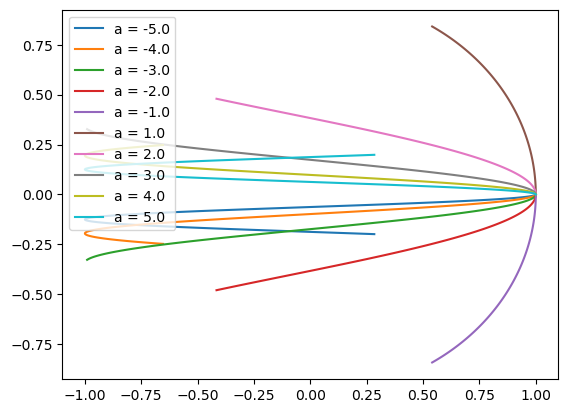

In [2]:
# i. Fix a family of paths in a functional way \emph{i.e.} fix a function $\Gamma : \mathbb{R} \to C^1([0,1]; \mathbb{R}^d)$.

def Gamma(a):
    return lambda t : np.array([np.cos(a*t), np.sin(t/a)]).T


# Plot some members of the family

timesteps = np.linspace(0,1, 100)

a_s = np.linspace(-5,5, 11)
for a_ in a_s:
    if a_ == 0:
        continue
    plt.plot(Gamma(a_)(np.linspace(0,1, 100))[:,0], Gamma(a_)(np.linspace(0,1, 100))[:,1], label = "a = {}".format(a_))

plt.legend(loc = 2)
plt.show()

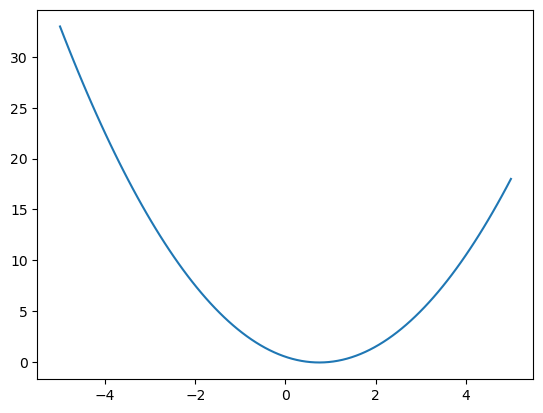

In [3]:
# ii. Fix a target function $F : \mathbb{R} \to \mathbb{R}$.

def F(a):
    return (a-1)*(a - 0.5)

# Plot the function F

params = np.linspace(-5,5, 100)
plt.plot(params, F(params))

<class 'torch.Tensor'> torch.Size([1, 200])
<class 'torch.Tensor'> torch.Size([200, 1])
<class 'torch.Tensor'> torch.Size([2, 200, 200])
<class 'torch.Tensor'> torch.Size([2, 200, 1])


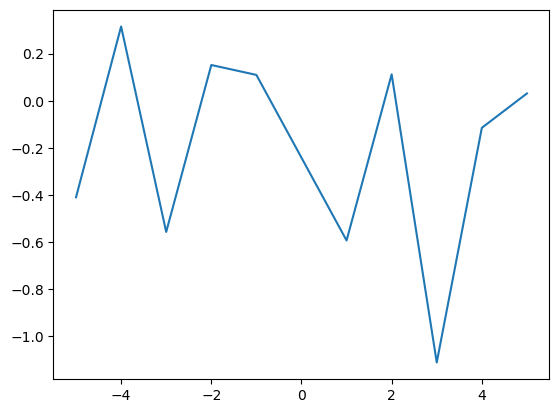

In [4]:
# iii. Learn $G: C^1([0,1]; \mathbb{R}^d) \to \mathbb{R}$ such that $F \sim G \circ \Gamma$.

# Parameters
N, d, M = 200, 2, 101
activation = lambda x: x
sigmas = {"sigma_0": 1.0, "sigma_A": 1.0, "sigma_b": 1.0}
partition = torch.linspace(0, 1, M)

# Sample the paths
batch = 10

X = torch.zeros(batch, M, d)
a_s = np.linspace(-5, 5, batch+1)
a_s = np.delete(a_s, int(batch/2))

for i in range(batch):
    X[i] = torch.tensor(Gamma(a_s[i])(np.linspace(0, 1, M)))

y = torch.tensor(F(a_s)).float()

# Initialize cResNet
model = cResNet(d, N, activation, sigmas, partition)

# Compute initial values
for param in model.parameters():
    print(type(param.data), param.size())

res = model.forward(X)
res_np = res.cpu().detach().numpy()

plt.plot(a_s, res_np)

In [5]:
# Training the model
EPOCHS, save_state_num, lr = 200, 50, .01
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_mask = [2, 4, 7] #np.random.permutation(batch)[:int(batch/3)]
test_mask = [i not in train_mask for i in range(batch)]
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

partial_results = torch.zeros( (int(EPOCHS/save_state_num) + 1, batch) )

for epoch in tqdm(range(EPOCHS)):

    # Save current state at checkpoint
    if epoch % save_state_num == 0:
        partial_results[int(epoch/save_state_num)] = model(X)

    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward(retain_graph=True)
    #optimizer.step()
    for p in model.parameters():
        p.data.add_(p.grad.data * -lr)

print(loss)

100%|██████████| 200/200 [00:09<00:00, 21.45it/s]

tensor(2.0346e-05, grad_fn=<MseLossBackward0>)


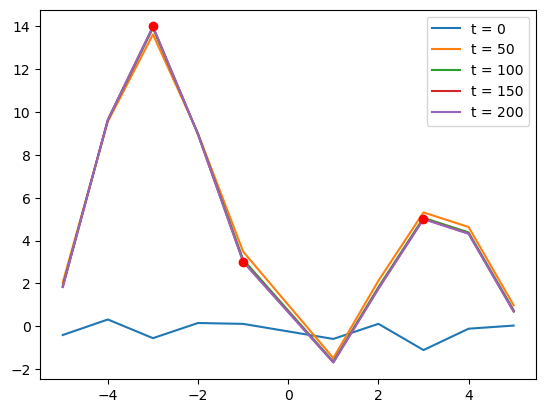

In [6]:
partial_results[-1] = model.forward(X)
partial_results_np = partial_results.cpu().detach().numpy()

for i in range(len(partial_results)):
    plt.plot(a_s, partial_results_np[i], label='t = {}'.format(i*save_state_num))

plt.plot(a_s[train_mask], y_train, 'o', color='red')
plt.legend()
plt.show()

Do the entries remain Gaussian in training? Pretty much yes!

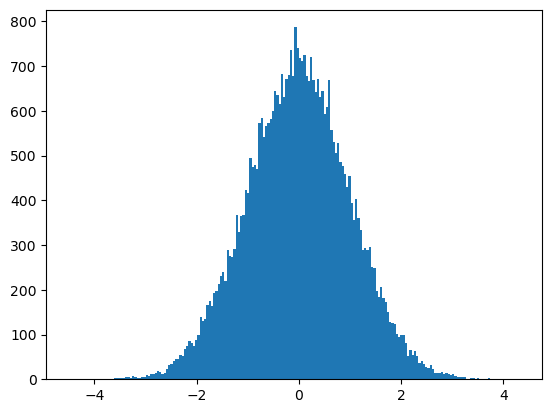

In [7]:
plt.hist(model.Aks_param[0].flatten().cpu().detach().numpy(), bins = 200)
plt.show()

Compute the NTK

In [9]:
NTK = NTKer_new(sigmas=sigmas)
SK = NeuralSigKer(sigmas=sigmas)

# Compute SigKer and NTK Gram Matrix
SKxx = SK._kernel_same(X)
SK_Gram = SK.compute_Gram(X, X, SKxx, SKxx, sym=True, max_batch=30)
NTK_Gram = NTK.compute_Gram(X, X, SKxx, SKxx, SK_Gram, sym=True, max_batch=30)

In [10]:
SK_Gram_Train = SK_Gram[:,:,-1,-1][train_mask][: , train_mask]
#SK_Gram_Test_Train = SK_Gram[:,:,-1,-1][test_mask][: , train_mask]
#SK_Gram_Test_Test = SK_Gram[:,:,-1,-1][test_mask][: , test_mask]
SK_Gram_Test_Train = SK_Gram[:,:,-1,-1][:][: , train_mask]
SK_Gram_Test_Test = SK_Gram[:,:,-1,-1]

NTK_Gram_Train = NTK_Gram[:,:,-1,-1][train_mask][: , train_mask]
#NTK_Gram_Test_Train = NTK_Gram[:,:,-1,-1][test_mask][: , train_mask]
NTK_Gram_Test_Train = NTK_Gram[:,:,-1,-1][:][: , train_mask]

Compute NTK predictor

In [11]:
class NTK_predictor:
    def __init__(self, SK_Gram_Train, NTK_Gram_Train, y_train):

        self.SK_Gram_Train = SK_Gram_Train
        self.SK_Gram_Train_inv = SK_Gram_Train.inverse()

        self.NTK_Gram_Train = NTK_Gram_Train
        self.NTK_Gram_Train_inv = NTK_Gram_Train.inverse()

        self.Y = y_train

        self.SK_Gram_Test_Train = None
        self.SK_Gram_Test_Test = None
        self.NTK_Gram_Test_Train = None

    def forward(self, t, SK_Gram_Test_Train=None, SK_Gram_Test_Test=None, NTK_Gram_Test_Train=None, lr=1.0):

        # Check previous values, if empty throw error, and update them.
        if SK_Gram_Test_Train is None:
            assert not(self.SK_Gram_Test_Train is None)
        else:
            self.SK_Gram_Test_Train = SK_Gram_Test_Train

        if SK_Gram_Test_Test is None:
            assert not(self.SK_Gram_Test_Test is None)
        else:
            self.SK_Gram_Test_Test = SK_Gram_Test_Test

        if NTK_Gram_Test_Train is None:
            assert not(self.NTK_Gram_Test_Train is None)
        else:
            self.NTK_Gram_Test_Train = NTK_Gram_Test_Train

        exp_matrix = torch.linalg.matrix_exp(-lr * t * self.NTK_Gram_Train)
        theta_theta_inv = torch.matmul(NTK_Gram_Test_Train, self.NTK_Gram_Train_inv)
        theta_theta_inv_exp_t = torch.matmul(theta_theta_inv, torch.eye(self.NTK_Gram_Train.shape[0]) - exp_matrix)

        # Predict mean
        mean = torch.matmul(theta_theta_inv_exp_t, self.Y)

        # Predict STD
        std = SK_Gram_Test_Test
        std_1 = torch.matmul(theta_theta_inv_exp_t, self.SK_Gram_Train)
        std_1 = torch.matmul(std_1, theta_theta_inv_exp_t.T)
        std_2 = torch.matmul(theta_theta_inv_exp_t, self.SK_Gram_Test_Train.T)
        std = std + std_1 - std_2 - std_2.T

        return mean, std

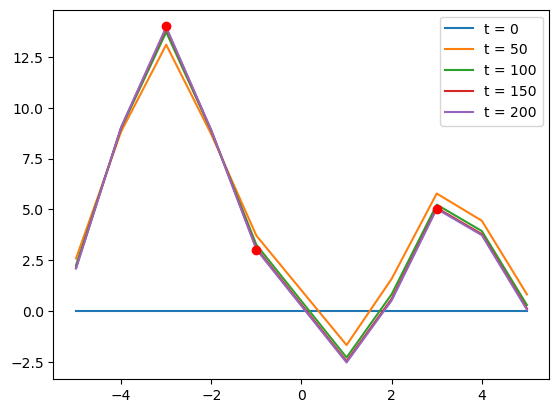

In [12]:
# Initialize Kernel Machine
kernel_predictor = NTK_predictor(SK_Gram_Train, NTK_Gram_Train, y_train)

# Compute partial results
partial_kernel_results_mean = torch.zeros( (int(EPOCHS/save_state_num) + 1, batch) )
partial_kernel_results_var = torch.zeros( (int(EPOCHS/save_state_num) + 1, batch, batch) )

for i in range(len(partial_kernel_results_mean)):
    pred_i = kernel_predictor.forward(i*save_state_num, SK_Gram_Test_Train, SK_Gram_Test_Test, NTK_Gram_Test_Train, lr)
    partial_kernel_results_mean[i] = pred_i[0]
    partial_kernel_results_var[i] = pred_i[1]

# Plot results
partial_kernel_results_mean_np = partial_kernel_results_mean.cpu().detach().numpy()

for i in range(len(partial_kernel_results_mean)):
    plt.plot(a_s, partial_kernel_results_mean_np[i], label='t = {}'.format(i*save_state_num))

plt.plot(a_s[train_mask], y_train, 'o', color='red')
plt.legend()
plt.show()

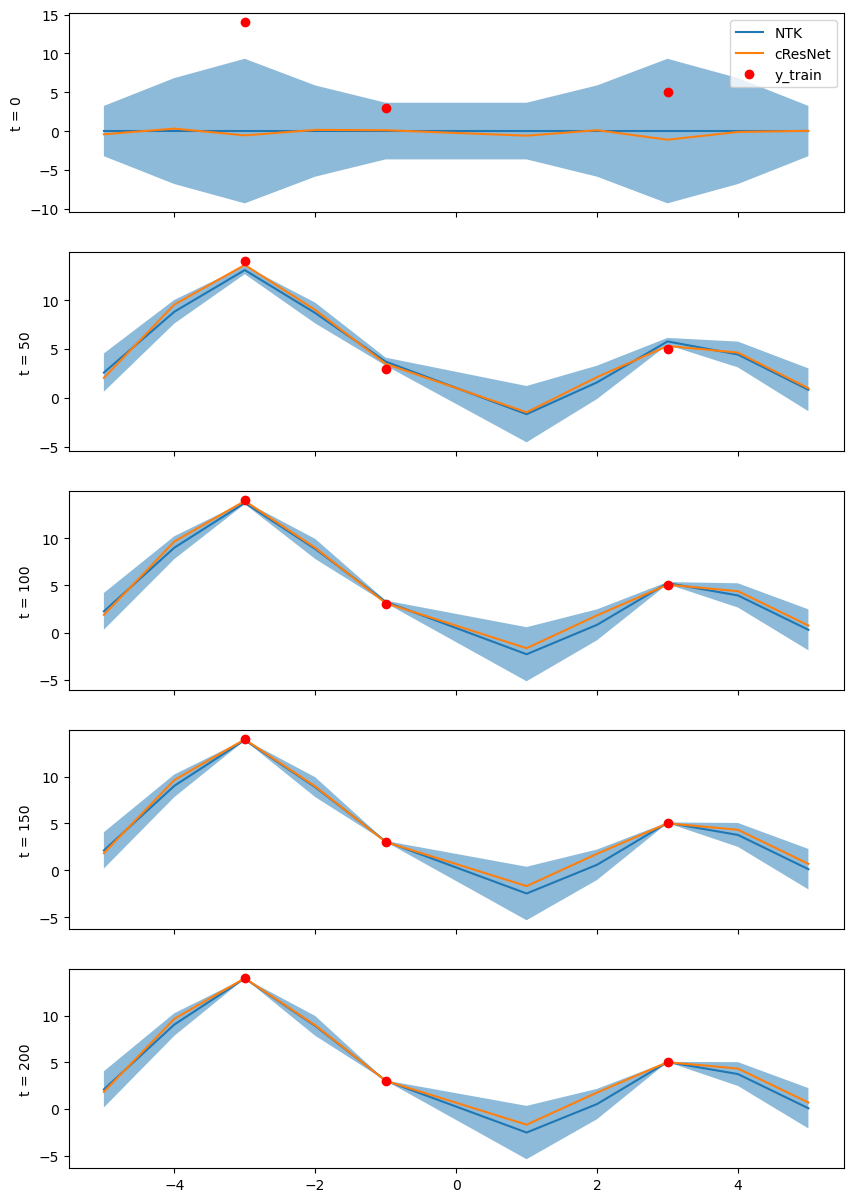

In [13]:
# iv. Plot $G \circ \Gamma$ trough training against the NTK results.

fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 15)

for j in range(len(partial_kernel_results_mean)):
    # Save stds and means
    stds_j = partial_kernel_results_var[j].diag().sqrt().mul(2.0).cpu().detach().numpy()
    means_j = partial_kernel_results_mean_np[j]

    # Plot
    ax[j].set_ylabel('t = {}'.format(j*save_state_num))
    ax[j].plot(a_s, means_j, label='NTK')
    ax[j].plot(a_s, partial_results_np[j], label='cResNet')

    ax[j].fill_between(a_s, means_j + stds_j, means_j - stds_j, alpha=0.5)

    ax[j].plot(a_s[train_mask], y_train, 'o', color='red', label='y_train')


ax[0].legend()
plt.show()

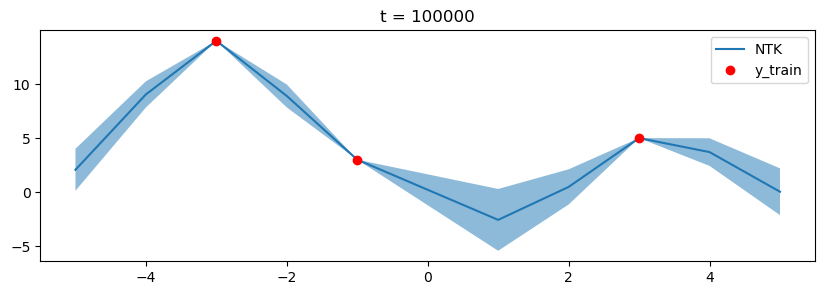

In [14]:
## To \infty and beyond!!

T = 100000
pred_inf = kernel_predictor.forward(T, SK_Gram_Test_Train, SK_Gram_Test_Test, NTK_Gram_Test_Train, lr)


# Save stds and means
means_inf = pred_inf[0].cpu().detach().numpy()
stds_inf = pred_inf[1].diag().sqrt().mul(2.0).cpu().detach().numpy()

# Plot
plt.figure(figsize=(10, 3))
plt.title('t = {}'.format(T))
plt.plot(a_s, means_inf, label='NTK')
#plt.plot(a_s, partial_results_np[-1], label='cResNet')

plt.fill_between(a_s, means_inf + stds_inf, means_inf - stds_inf, alpha=0.5)

plt.plot(a_s[train_mask], y_train, 'o', color='red', label='y_train')
plt.legend()
plt.show()
